# 07_differential_effects


in this notebook, i analyze cis effects (diffs between REF and ALT seqs in CM and VSMC)

In [26]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from itertools import combinations 
from scipy.integrate import cumtrapz
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [27]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## functions

In [5]:
def diff_sig_status(row):
    if row.CM_status == "significant effect" and row.VSMC_status == "significant effect":
        return "sig_both"
    elif row.CM_status == "significant effect" and row.VSMC_status == "no effect":
        return "sig_CM"
    elif row.CM_status == "no effect" and row.VSMC_status == "significant effect":
        return "sig_VSMC"
    else:
        return "not_sig_both"

## variables 

In [6]:
data_dir = "../../../data/02_activs/"

native_f = "%s/comp_results.CM.new_back.txt" % data_dir
native_f_vsmc = "%s/comp_results.VSMC.new_back.txt" % data_dir

In [7]:
index_f = "../../../data/design/Hypertension__pooled.index.txt"
mital_snps_f = "../../../data/design/name_Mital_SNPS.txt"

## 1. import data 

In [8]:
data = pd.read_table(native_f, sep="\t").reset_index()
data.head()

,index,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
0,4625__CONTROL_SNP_INDIV,443.728165,1.671327e-98,2.677466e-95,1.0,101.0,5.0,4.0,0.990103
1,4621__CONTROL_SNP_INDIV,18.523928,1.677846e-05,1.333196e-04,1.0,101.0,5.0,4.0,0.210511
2,4627__CONTROL_SNP_INDIV,72.258054,1.888185e-17,2.110376e-15,1.0,101.0,5.0,4.0,0.447188
3,4620__CONTROL_SNP_INDIV,42.557365,6.863931e-11,2.499095e-09,1.0,101.0,5.0,4.0,0.316654
4,4634__CONTROL_SNP_INDIV,51.275819,8.025819e-13,4.103413e-11,1.0,39.0,5.0,4.0,-1.395349


In [9]:
data.columns = ["index", "stat_comp", "pval_comp", "fdr_comp", "df.test_comp", "df.dna_comp", 
                  "df.rna.full_comp", "df.rna.red_comp", "logFC_comp"]
#comp["index"] = comp.apply(fix_ctrl_id, axis=1)
data.sample(5)

,index,stat_comp,pval_comp,fdr_comp,df.test_comp,df.dna_comp,df.rna.full_comp,df.rna.red_comp,logFC_comp
3429,2797__WILDTYPE_SNP_INDIV,2.852074,9.125613e-02,0.174801,1.0,26.0,5.0,4.0,-0.178460
1725,16__WILDTYPE_SNP_INDIV,1.834263,1.756248e-01,0.289158,1.0,26.0,5.0,4.0,0.123560
1366,2920__WILDTYPE_SNP_INDIV,1.358812,2.437435e-01,0.372220,1.0,4.0,5.0,4.0,1.067880
1030,2586__WILDTYPE_SNP_INDIV,28.421432,9.757909e-08,0.000002,1.0,26.0,5.0,4.0,-0.576597
3452,3311__WILDTYPE_SNP_INDIV,11.057787,8.831547e-04,0.003855,1.0,21.0,5.0,4.0,-0.784781


In [10]:
data_vsmc = pd.read_table(native_f_vsmc, sep="\t").reset_index()
data_vsmc.head()

,index,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
0,4625__CONTROL_SNP_INDIV,33.863300,5.912352e-09,0.000001,1.0,101.0,5.0,4.0,0.478453
1,4621__CONTROL_SNP_INDIV,0.663435,4.153497e-01,0.672945,1.0,101.0,5.0,4.0,0.123628
2,4627__CONTROL_SNP_INDIV,12.347427,4.415947e-04,0.011759,1.0,101.0,5.0,4.0,0.462044
3,4620__CONTROL_SNP_INDIV,13.599653,2.262274e-04,0.007293,1.0,101.0,5.0,4.0,0.499346
4,4634__CONTROL_SNP_INDIV,0.469618,4.931630e-01,0.733857,1.0,39.0,5.0,4.0,-0.359944


In [11]:
data_vsmc.columns = ["index", "stat_comp", "pval_comp", "fdr_comp", "df.test_comp", "df.dna_comp", 
                  "df.rna.full_comp", "df.rna.red_comp", "logFC_comp"]
#comp["index"] = comp.apply(fix_ctrl_id, axis=1)
data_vsmc.sample(5)

,index,stat_comp,pval_comp,fdr_comp,df.test_comp,df.dna_comp,df.rna.full_comp,df.rna.red_comp,logFC_comp
4092,2436__WILDTYPE_SNP_INDIV,1.445316,2.292810e-01,5.042259e-01,1.0,23.0,5.0,4.0,0.602376
1409,4129__WILDTYPE_SNP_INDIV,45.427089,1.584279e-11,4.223865e-09,1.0,26.0,5.0,4.0,0.815462
516,1209__WILDTYPE_SNP_INDIV,2.610022,1.061903e-01,3.317755e-01,1.0,26.0,5.0,4.0,0.297526
1729,167__WILDTYPE_SNP_INDIV,2.918584,8.756466e-02,2.986658e-01,1.0,23.0,5.0,4.0,-0.874156
3099,2258__WILDTYPE_SNP_INDIV,0.001014,9.745982e-01,9.874193e-01,1.0,26.0,5.0,4.0,0.007530


In [12]:
index = pd.read_table(index_f, sep="\t")
index['dupe_info'] = index['tile_id'].str.split('.',expand=True)[0]
index.head()

,element,tile_type,tile_id,name,parse_details,chrom,start,end,strand,actual_start,...,RE_2,RE_3,REs_mutated,unique_name,snp,barcode,oligo,oligo_len,pool_num,dupe_info
0,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.1,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,CTGCTTGATAC,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1,1
1,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.2,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,CTCGGCGAACA,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1,1
2,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.3,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,CATGTTCGAGT,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1,1
3,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.4,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,ATCGTAAACTC,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1,1
4,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.5,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,ATAGGTTCGCT,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1,1


In [13]:
## mital snps 
mital_snps = pd.read_table(mital_snps_f, sep="\t")
mital_snps.head()

,name
0,chr1:2985619:2985754__rs886940486__1:2985687:C:T
1,chr1:2985628:2985763__1:2985696:G:C__1:2985696...
2,chr1:115259631:115259766__1:115259699:C:G__1:1...
3,chr1:156084367:156084502__1:156084435:A:G__1:1...
4,chr1:156084826:156084961__1:156084894:G:C__1:1...


In [14]:
index_no_mital = index[~index["name"].isin(mital_snps['name'])]

In [15]:
index_elem = index_no_mital[["element", "tile_type", "name",'unique_name', "chrom", "strand", "actual_start", 
                    "actual_end", "dupe_info"]]
index_elem = index_elem.drop_duplicates()

## 2. merge data 

In [16]:
index_elem = index_elem[index_elem["tile_type"].str.contains("WILDTYPE")]
index_elem.head()

,element,tile_type,name,unique_name,chrom,strand,actual_start,actual_end,dupe_info
0,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,+,106410709,106410844,1
25,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_SNP_INDIV,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,+,106410709,106410844,1
50,TTAGCAACTTTACTAGTCTCATCAATGCAGGAATGGAGGTTACTTG...,WILDTYPE_BUT_HAS_SNP,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925__rs17477177__7:106411...,chr7,+,106411790,106411925,2
75,TTAGCAACTTTACTAGTCTCATCAATGCAGGAATGGAGGTTACTTG...,WILDTYPE_SNP_INDIV,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925__rs17477177__7:106411...,chr7,+,106411790,106411925,2
100,AAAACTAAGATTACAGTTAAAAATTACACTGTGATATATATATATC...,WILDTYPE_BUT_HAS_SNP,chr7:106412014:106412149__rs62481856__7:106412...,chr7:106412014:106412149__rs62481856__7:106412...,chr7,+,106412014,106412149,3


In [17]:
data = data[data["index"].str.contains("WILDTYPE")]
data.head()

,index,stat_comp,pval_comp,fdr_comp,df.test_comp,df.dna_comp,df.rna.full_comp,df.rna.red_comp,logFC_comp
21,2460__WILDTYPE_SNP_INDIV,0.002270,0.962001,0.975808,1.0,26.0,5.0,4.0,-0.004084
22,1163__WILDTYPE_SNP_INDIV,1.350091,0.245262,0.373644,1.0,26.0,5.0,4.0,-0.130726
23,1115__WILDTYPE_SNP_INDIV,1.966163,0.160856,0.271683,1.0,26.0,5.0,4.0,-0.199032
24,2812__WILDTYPE_SNP_INDIV,0.018015,0.893229,0.932034,1.0,9.0,5.0,4.0,-0.068022
25,1079__WILDTYPE_SNP_INDIV,8.169896,0.004259,0.014344,1.0,17.0,5.0,4.0,-0.753282


In [18]:
data_vsmc = data_vsmc[data_vsmc["index"].str.contains("WILDTYPE")]
data_vsmc.head()

,index,stat_comp,pval_comp,fdr_comp,df.test_comp,df.dna_comp,df.rna.full_comp,df.rna.red_comp,logFC_comp
21,2460__WILDTYPE_SNP_INDIV,0.073462,0.786361,0.899532,1.0,26.0,5.0,4.0,0.059866
22,1163__WILDTYPE_SNP_INDIV,0.000241,0.987601,0.993527,1.0,26.0,5.0,4.0,0.004192
23,1115__WILDTYPE_SNP_INDIV,0.440261,0.506997,0.742086,1.0,26.0,5.0,4.0,0.293848
24,1079__WILDTYPE_SNP_INDIV,4.302640,0.038053,0.182994,1.0,17.0,5.0,4.0,-1.077877
25,4308__WILDTYPE_SNP_INDIV,6.866934,0.008781,0.077816,1.0,10.0,5.0,4.0,-1.885874


In [19]:
data['dupe_info'] = data['index'].str.split('__',expand=True)[0]
data_vsmc['dupe_info'] = data_vsmc['index'].str.split('__',expand=True)[0]

In [20]:
print(len(data))
data_elem = data.merge(index_elem[["unique_name","dupe_info"]], left_on=["dupe_info"],
                       right_on=["dupe_info"])
data_elem = data_elem.merge(data_vsmc, left_on=["dupe_info"],
                            right_on=["dupe_info"], suffixes=("_CM", "_VSMC"))
#data_elem.drop(["tss_id_human", "tss_id_mouse"], axis=1, inplace=True)
print(len(data))
data_elem.head()

4661
4661


,index_CM,stat_comp_CM,pval_comp_CM,fdr_comp_CM,df.test_comp_CM,df.dna_comp_CM,df.rna.full_comp_CM,df.rna.red_comp_CM,logFC_comp_CM,dupe_info,unique_name,index_VSMC,stat_comp_VSMC,pval_comp_VSMC,fdr_comp_VSMC,df.test_comp_VSMC,df.dna_comp_VSMC,df.rna.full_comp_VSMC,df.rna.red_comp_VSMC,logFC_comp_VSMC
0,2460__WILDTYPE_SNP_INDIV,0.002270,0.962001,0.975808,1.0,26.0,5.0,4.0,-0.004084,2460,chr7:131096670:131096805__rs9719973__7:1310967...,2460__WILDTYPE_SNP_INDIV,0.073462,0.786361,0.899532,1.0,26.0,5.0,4.0,0.059866
1,2460__WILDTYPE_SNP_INDIV,0.002270,0.962001,0.975808,1.0,26.0,5.0,4.0,-0.004084,2460,chr7:131096670:131096805__rs9719973__7:1310967...,2460__WILDTYPE_SNP_INDIV,0.073462,0.786361,0.899532,1.0,26.0,5.0,4.0,0.059866
2,1163__WILDTYPE_SNP_INDIV,1.350091,0.245262,0.373644,1.0,26.0,5.0,4.0,-0.130726,1163,chr3:47797488:47797623__rs13098128__3:47797556...,1163__WILDTYPE_SNP_INDIV,0.000241,0.987601,0.993527,1.0,26.0,5.0,4.0,0.004192
3,1163__WILDTYPE_SNP_INDIV,1.350091,0.245262,0.373644,1.0,26.0,5.0,4.0,-0.130726,1163,chr3:47797488:47797623__rs13098128__3:47797556...,1163__WILDTYPE_SNP_INDIV,0.000241,0.987601,0.993527,1.0,26.0,5.0,4.0,0.004192
4,1115__WILDTYPE_SNP_INDIV,1.966163,0.160856,0.271683,1.0,26.0,5.0,4.0,-0.199032,1115,chr1:113206852:113206987__rs6682678__1:1132069...,1115__WILDTYPE_SNP_INDIV,0.440261,0.506997,0.742086,1.0,26.0,5.0,4.0,0.293848


## 3. get diff effects

In [21]:
def diff_CM_status(row):
    if row.fdr_comp_CM < 0.05:
        return "significant effect"
    else:
        return "no effect"

def diff_VSMC_status(row):
    if row.fdr_comp_VSMC < 0.05:
        return "significant effect"
    else:
        return "no effect"
    

In [22]:
data_elem["CM_status"] = data_elem.apply(diff_CM_status, axis=1)
data_elem["VSMC_status"] = data_elem.apply(diff_VSMC_status, axis=1)
data_elem.head()

,index_CM,stat_comp_CM,pval_comp_CM,fdr_comp_CM,df.test_comp_CM,df.dna_comp_CM,df.rna.full_comp_CM,df.rna.red_comp_CM,logFC_comp_CM,dupe_info,...,stat_comp_VSMC,pval_comp_VSMC,fdr_comp_VSMC,df.test_comp_VSMC,df.dna_comp_VSMC,df.rna.full_comp_VSMC,df.rna.red_comp_VSMC,logFC_comp_VSMC,CM_status,VSMC_status
0,2460__WILDTYPE_SNP_INDIV,0.002270,0.962001,0.975808,1.0,26.0,5.0,4.0,-0.004084,2460,...,0.073462,0.786361,0.899532,1.0,26.0,5.0,4.0,0.059866,no effect,no effect
1,2460__WILDTYPE_SNP_INDIV,0.002270,0.962001,0.975808,1.0,26.0,5.0,4.0,-0.004084,2460,...,0.073462,0.786361,0.899532,1.0,26.0,5.0,4.0,0.059866,no effect,no effect
2,1163__WILDTYPE_SNP_INDIV,1.350091,0.245262,0.373644,1.0,26.0,5.0,4.0,-0.130726,1163,...,0.000241,0.987601,0.993527,1.0,26.0,5.0,4.0,0.004192,no effect,no effect
3,1163__WILDTYPE_SNP_INDIV,1.350091,0.245262,0.373644,1.0,26.0,5.0,4.0,-0.130726,1163,...,0.000241,0.987601,0.993527,1.0,26.0,5.0,4.0,0.004192,no effect,no effect
4,1115__WILDTYPE_SNP_INDIV,1.966163,0.160856,0.271683,1.0,26.0,5.0,4.0,-0.199032,1115,...,0.440261,0.506997,0.742086,1.0,26.0,5.0,4.0,0.293848,no effect,no effect


In [23]:
print(len(data_elem))
data_elem.drop_duplicates(inplace=True)
len(data_elem)

9174


4587

## 4. count differential effects

In [24]:
cis_order = ["no effect", "significant effect"]
cis_pal = {"no effect": "gray", "significant effect": "black"}

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


percent sig: 0.3897972531066056


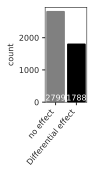

In [27]:
fig, ax = plt.subplots(figsize=(0.75, 1.75), nrows=1, ncols=1)

sns.countplot(data=data_elem, x="CM_status", palette=cis_pal, order=cis_order, linewidth=2, 
              edgecolor=cis_pal.values(), ax=ax)
ax.set_xticklabels(["no effect", "Differential effect"], va="top", ha="right", rotation=50)
ax.set_xlabel("")

tot = 0
for i, l in enumerate(cis_order):
    n = len(data_elem[data_elem["CM_status"] == l])
    tot += n
    ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)
print("percent sig: %s" % (n/tot))

plt.show()
#fig.savefig("Fig2C_Diff_CM.svg", dpi="figure", bbox_inches="tight")
plt.close()

percent sig: 0.08524089819053848


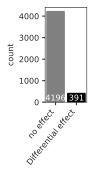

In [28]:
fig, ax = plt.subplots(figsize=(0.75, 1.75), nrows=1, ncols=1)

sns.countplot(data=data_elem, x="VSMC_status", palette=cis_pal, order=cis_order, linewidth=2, 
              edgecolor=cis_pal.values(), ax=ax)
ax.set_xticklabels(["no effect", "Differential effect"], va="top", ha="right", rotation=50)
ax.set_xlabel("")

tot = 0
for i, l in enumerate(cis_order):
    n = len(data_elem[data_elem["VSMC_status"] == l])
    tot += n
    ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)
print("percent sig: %s" % (n/tot))

plt.show()
#fig.savefig("Fig2C_Diff_VSMC.svg", dpi="figure", bbox_inches="tight")
plt.close()

## 5. plot  effect sizes between VSMC and CM

In [25]:
df = data_elem.copy()

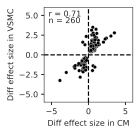

In [32]:
df["sig_status"] = df.apply(diff_sig_status, axis=1)

# plot effect size agreement b/w the two cells
fig, ax = plt.subplots(figsize=(1.6, 1.75), nrows=1, ncols=1)

sig_CM = df[df["sig_status"] == "sig_CM"]
sig_VSMC = df[df["sig_status"] == "sig_VSMC"]
sig_both = df[df["sig_status"] == "sig_both"]
not_sig = df[df["sig_status"] == "not_sig_both"]

#ax.scatter(not_sig["logFC_comp_CM"], not_sig["logFC_comp_VSMC"], s=10, alpha=0.75, 
#           color="gray", linewidths=0.25, edgecolors="white")
ax.scatter(sig_both["logFC_comp_CM"], sig_both["logFC_comp_VSMC"], s=12, alpha=1, 
           color="black", linewidths=0.25, edgecolors="white")
#ax.scatter(sig_VSMC["logFC_comp_CM"], sig_VSMC["logFC_comp_VSMC"], s=10, alpha=0.75, 
#           color=sns.color_palette("Set2")[0], linewidths=0.25, edgecolors="white")
#ax.scatter(sig_CM["logFC_comp_CM"], sig_CM["logFC_comp_VSMC"], s=10, alpha=0.75, 
#           color=sns.color_palette("Set2")[1], linewidths=0.25, edgecolors="white")
#ax.scatter(sig_both["logFC_comp_CM"], sig_both["logFC_comp_VSMC"], s=12, alpha=1, 
#           color="black", linewidths=0.25, edgecolors="white")

plt.xlabel("Diff effect size in CM")
plt.ylabel("Diff effect size in VSMC")

ax.axhline(y=0, color="black", linestyle="dashed")
ax.axvline(x=0, color="black", linestyle="dashed")
ax.set_xlim((-6, 6))
ax.set_ylim((-6, 6))

# annotate corr
no_nan = sig_both[(~pd.isnull(sig_both["logFC_comp_CM"])) & (~pd.isnull(sig_both["logFC_comp_VSMC"]))]
r, p = spearmanr(no_nan["logFC_comp_CM"], no_nan["logFC_comp_VSMC"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
plt.show()
fig.savefig("Fig1E_comparison_fc_cells_onlyreg.svg", dpi="figure", bbox_inches="tight")
plt.close()

In [29]:
df["sig_status"] = df.apply(diff_sig_status, axis=1)

In [34]:
no_nan = df[(~pd.isnull(df["logFC_comp_CM"])) & (~pd.isnull(df["logFC_comp_VSMC"]))]
r, p = spearmanr(no_nan[no_nan["sig_status"] != "not_sig_both"]["logFC_comp_CM"], no_nan[no_nan["sig_status"] != "not_sig_both"]["logFC_comp_VSMC"])


In [35]:
print(r,p)

0.6106587655088432 1.655683974869421e-196


## 6. correlation logFC and number of motifs predicted to be disrupted 

In [31]:
## motif info 
motifs = pd.read_table("../../../data/TF_Analysis/motifs_disruption_analysis.txt", sep='\t')
motifs.head()

,stat_comp,pval_comp,fdr_comp,df.test_comp,df.dna_comp,df.rna.full_comp,df.rna.red_comp,logFC_comp,dupe_info,element_ref,...,n_identical_motifs,n_partial_motifs,n_turnover_motifs,delta_motifs,perc_shared_motifs,perc_identical_motifs,perc_partial_motifs,perc_turnover_motifs,abs_delta_motifs,cis_status_one
0,0.002270,0.962001,0.975808,1.0,26.0,5.0,4.0,-0.004084,2460,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,...,5,0,0,0,100.0,100.0,0.0,0.0,0,no diff effect
1,1.350091,0.245262,0.373644,1.0,26.0,5.0,4.0,-0.130726,1163,AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCT...,...,15,0,0,0,100.0,100.0,0.0,0.0,0,no diff effect
2,1.966163,0.160856,0.271683,1.0,26.0,5.0,4.0,-0.199032,1115,AAAAAAAAAAAAAAAAAAAGATACTTATTTTTGTCCTTTAAACAAG...,...,1,0,0,0,100.0,100.0,0.0,0.0,0,no diff effect
3,0.018015,0.893229,0.932034,1.0,9.0,5.0,4.0,-0.068022,2812,AAAAAAAAAAAAAAAAATGCAATAGATGTATATATACTGAAGGGGC...,...,0,0,0,0,NaN,NaN,NaN,NaN,0,no diff effect
4,8.169896,0.004259,0.014344,1.0,17.0,5.0,4.0,-0.753282,1079,AAAAAAAAAAAAAAGAAAAGAAAAGAAAATAGACTGTAAGAAATTG...,...,0,0,0,0,NaN,NaN,NaN,NaN,0,significant diff effect


In [33]:
motifs["dupe_info"] = motifs["dupe_info"].astype(str)
data_elem_mot = data_elem.merge(motifs[["dupe_info","total_motifs","total_shared_motifs", "n_identical_motifs", "n_partial_motifs", "n_turnover_motifs","delta_motifs", "perc_shared_motifs", "perc_identical_motifs", "perc_partial_motifs", "perc_turnover_motifs", "abs_delta_motifs"]], 
                            left_on=["dupe_info"], right_on=["dupe_info"])
print(len(data_elem_mot))
data_elem_mot.head()

4587


,index_CM,stat_comp_CM,pval_comp_CM,fdr_comp_CM,df.test_comp_CM,df.dna_comp_CM,df.rna.full_comp_CM,df.rna.red_comp_CM,logFC_comp_CM,dupe_info,...,total_shared_motifs,n_identical_motifs,n_partial_motifs,n_turnover_motifs,delta_motifs,perc_shared_motifs,perc_identical_motifs,perc_partial_motifs,perc_turnover_motifs,abs_delta_motifs
0,2460__WILDTYPE_SNP_INDIV,0.002270,0.962001,0.975808,1.0,26.0,5.0,4.0,-0.004084,2460,...,5,5,0,0,0,100.0,100.0,0.0,0.0,0
1,1163__WILDTYPE_SNP_INDIV,1.350091,0.245262,0.373644,1.0,26.0,5.0,4.0,-0.130726,1163,...,15,15,0,0,0,100.0,100.0,0.0,0.0,0
2,1115__WILDTYPE_SNP_INDIV,1.966163,0.160856,0.271683,1.0,26.0,5.0,4.0,-0.199032,1115,...,1,1,0,0,0,100.0,100.0,0.0,0.0,0
3,1079__WILDTYPE_SNP_INDIV,8.169896,0.004259,0.014344,1.0,17.0,5.0,4.0,-0.753282,1079,...,0,0,0,0,0,NaN,NaN,NaN,NaN,0
4,4308__WILDTYPE_SNP_INDIV,14.190327,0.000165,0.000943,1.0,10.0,5.0,4.0,-1.300271,4308,...,0,0,0,0,0,NaN,NaN,NaN,NaN,0


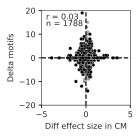

In [35]:
# plot effect size agreement b/w the two cells
fig, ax = plt.subplots(figsize=(1.6, 1.75), nrows=1, ncols=1)

sig = data_elem_mot[data_elem_mot["CM_status"] == "significant effect"]
not_sig = data_elem_mot[data_elem_mot["CM_status"] != "significant effect"]

ax.scatter((not_sig["logFC_comp_CM"]), (not_sig["delta_motifs"]), s=10, alpha=0.75, 
           color="gray", linewidths=0.25, edgecolors="white")
ax.scatter((sig["logFC_comp_CM"]), (sig["delta_motifs"]), s=12, alpha=1, 
           color="black", linewidths=0.25, edgecolors="white")

plt.xlabel("Diff effect size in CM")
plt.ylabel("Delta motifs")

ax.axhline(y=0, color="black", linestyle="dashed")
ax.axvline(x=0, color="black", linestyle="dashed")
ax.set_xlim((-5, 5))
ax.set_ylim((-20, 20))

# annotate corr
no_nan = sig[(~pd.isnull(sig["logFC_comp_CM"])) & (~pd.isnull(sig["delta_motifs"]))]
r, p = spearmanr((no_nan["logFC_comp_CM"]), (no_nan["delta_motifs"]))
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
plt.show()
#fig.savefig("FigSupp_FC_motifs.svg", dpi="figure", bbox_inches="tight")
plt.close()

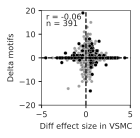

In [36]:
# plot effect size agreement b/w the two cells
fig, ax = plt.subplots(figsize=(1.6, 1.75), nrows=1, ncols=1)

sig = data_elem_mot[data_elem_mot["VSMC_status"] == "significant effect"]
not_sig = data_elem_mot[data_elem_mot["VSMC_status"] != "significant effect"]

ax.scatter((not_sig["logFC_comp_VSMC"]), (not_sig["delta_motifs"]), s=10, alpha=0.75, 
           color="gray", linewidths=0.25, edgecolors="white")
ax.scatter((sig["logFC_comp_VSMC"]), (sig["delta_motifs"]), s=12, alpha=1, 
           color="black", linewidths=0.25, edgecolors="white")

plt.xlabel("Diff effect size in VSMC")
plt.ylabel("Delta motifs")

ax.axhline(y=0, color="black", linestyle="dashed")
ax.axvline(x=0, color="black", linestyle="dashed")
ax.set_xlim((-5, 5))
ax.set_ylim((-20, 20))

# annotate corr
no_nan = sig[(~pd.isnull(sig["logFC_comp_VSMC"])) & (~pd.isnull(sig["delta_motifs"]))]
r, p = spearmanr((no_nan["logFC_comp_VSMC"]), (no_nan["delta_motifs"]))
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
plt.show()
#fig.savefig("FigSupp_FC_motifs.VSMC.svg", dpi="figure", bbox_inches="tight")
plt.close()

Text(0.95, 0.05, 'n = 1788')

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


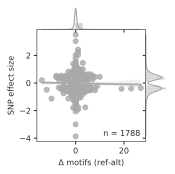

In [37]:
df = data_elem_mot[data_elem_mot["CM_status"] == "significant effect"]
g = sns.jointplot(data=df, x="delta_motifs", y="logFC_comp_CM", kind="reg", space=0, size=2.5, color="darkgrey", scatter_kws={"s": 25})
g.set_axis_labels(r"$\Delta$ motifs (ref-alt)", "SNP effect size")

# add n-value
g.ax_joint.annotate("n = %s" % len(df), ha="right", xy=(.95, .05), xycoords=g.ax_joint.transAxes, 
                    fontsize=fontsize)

#g.savefig("Fig_4B.pdf", dpi="figure", bbox_inches="tight")

## 7. plot correlation motifs disrupted vs active 1 or 2 cells

In [39]:
data_elem_mot.sample(5)

,index_CM,stat_comp_CM,pval_comp_CM,fdr_comp_CM,df.test_comp_CM,df.dna_comp_CM,df.rna.full_comp_CM,df.rna.red_comp_CM,logFC_comp_CM,dupe_info,...,total_shared_motifs,n_identical_motifs,n_partial_motifs,n_turnover_motifs,delta_motifs,perc_shared_motifs,perc_identical_motifs,perc_partial_motifs,perc_turnover_motifs,abs_delta_motifs
1811,551__WILDTYPE_SNP_INDIV,15.223015,0.000096,0.000592,1.0,25.0,5.0,4.0,0.709884,551,...,0,0,0,0,0,NaN,NaN,NaN,NaN,0
3589,740__WILDTYPE_SNP_INDIV,8.882609,0.002879,0.010348,1.0,26.0,5.0,4.0,-0.455570,740,...,5,2,3,6,-6,45.454545,40.0,60.0,54.545455,6
3320,3203__WILDTYPE_SNP_INDIV,4.425235,0.035411,0.082255,1.0,8.0,5.0,4.0,-0.934083,3203,...,0,0,0,0,0,NaN,NaN,NaN,NaN,0
1642,815__WILDTYPE_SNP_INDIV,0.567758,0.451151,0.585060,1.0,26.0,5.0,4.0,-0.073216,815,...,1,1,0,0,0,100.000000,100.0,0.0,0.000000,0
4299,4417__WILDTYPE_SNP_INDIV,2.216271,0.136563,0.239271,1.0,26.0,5.0,4.0,0.194040,4417,...,3,3,0,1,-1,75.000000,100.0,0.0,25.000000,1


In [40]:
data_elem_mot["sig_status"] = data_elem_mot.apply(diff_sig_status, axis=1)
data_elem_mot["sig_status"].value_counts()

not_sig_both    2668
sig_CM          1528
sig_both         260
sig_VSMC         131
Name: sig_status, dtype: int64

Text(0, 0.5, 'absolute value(delta motifs)')

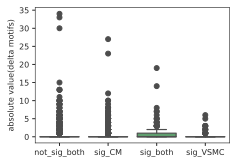

In [41]:
fig = plt.figure(figsize=(3.5, 2.5))
ax = sns.boxplot(data=data_elem_mot, x="sig_status", y="abs_delta_motifs", 
                 flierprops = dict(marker='o', markersize=5))
#ax.set_xticklabels(["eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)
mimic_r_boxplot(ax)
#ax.set_ylim((-0.35, 4))
plt.xlabel("")
plt.ylabel("absolute value(delta motifs)")

# add n-value
#ax.annotate(len(data_elem_mot[data_elem_mot["sig_status"] == "Enhancer"]), ha="center", va="top",
#            xy=(0, -0.1), fontsize=fontsize, color=TSS_CLASS_PALETTE["Enhancer"])

0.13141386014125572
0.014007706153958847
0.000727943438180919


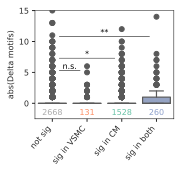

In [42]:
# plot some examples
order1 = ["not_sig_both", "sig_VSMC", "sig_CM","sig_both"]
pal2 = {"not_sig_both": "darkgray", "sig_VSMC": sns.color_palette("Set2")[1], 
        "sig_CM": sns.color_palette("Set2")[0], "sig_both": sns.color_palette("Set2")[2]}


tmp = data_elem_mot.copy()

fig, ax = plt.subplots(figsize=(2.5, 2), nrows=1, ncols=1)

sns.boxplot(data=tmp, x="sig_status", y=(tmp["abs_delta_motifs"]), order=order1, palette=pal2, 
            flierprops = dict(marker='o', markersize=5), ax=ax)
mimic_r_boxplot(ax)
ax.set_xticklabels(["not sig", "sig in VSMC", "sig in CM", "sig in both"], rotation=50, 
                   ha="right", va="top")
ax.set_ylabel("abs(Delta motifs)")
ax.set_title("")
ax.set_xlabel("")

for i, label in enumerate(order1):
    n = len(tmp[tmp["sig_status"] == label])
    ax.annotate(str(n), xy=(i, -0.9), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='top', 
                color=pal2[label], size=fontsize)

ax.set_ylim((-2.5, 15))
#ax.set_ylim((-1.5, 4))


# calc p-vals b/w dists
dist1 = np.asarray(tmp[tmp["sig_status"] == "not_sig_both"]["abs_delta_motifs"])
dist2 = np.asarray(tmp[tmp["sig_status"] == "sig_VSMC"]["abs_delta_motifs"])
dist3 = np.asarray(tmp[tmp["sig_status"] == "sig_CM"]["abs_delta_motifs"])
dist4 = np.asarray(tmp[tmp["sig_status"] == "sig_both"]["abs_delta_motifs"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]
dist3 = dist3[~np.isnan(dist3)]
dist4 = dist4[~np.isnan(dist4)]

u, pval1 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
u, pval2 = stats.mannwhitneyu(dist1, dist3, alternative="two-sided", use_continuity=False)
u, pval3 = stats.mannwhitneyu(dist1, dist4, alternative="two-sided", use_continuity=False)
#u, pval3 = stats.mannwhitneyu(dist1, dist4, alternative="two-sided", use_continuity=False)
print(pval1)
print(pval2)
print(pval3)

#annotate_pval(ax, 0.2, 0.8, 5.3, 0, 5.3, pval1, fontsize)
ax.plot([0.2, 0.2, 0.8, 0.8], [5.3, 5.3+0, 5.3+0, 5.3], c="black", lw=0.5)
if pval1 < 0.001:
    ax.text((0.2+0.8)*.5, 5.3, '**', ha='center', va='bottom', color="black", size=fontsize)
elif pval1 < 0.05:
    ax.text((0.2+0.8)*.5, 5.3, '*', ha='center', va='bottom', color="black", size=fontsize)
else:
    ax.text((0.2+0.8)*.5, 5.3, 'n.s.', ha='center', va='bottom', color="black", size=fontsize)
    
ax.plot([0.2, 0.2, 1.8, 1.8], [7.3, 7.3+0, 7.3+0, 7.3], c="black", lw=0.5)
if pval2 < 0.001:
    ax.text((0.2+1.8)*.5, 7.3, '**', ha='center', va='bottom', color="black", size=fontsize)
elif pval2 < 0.05:
    ax.text((0.2+1.8)*.5, 7.3, '*', ha='center', va='bottom', color="black", size=fontsize)
else:
    ax.text((0.2+1.8)*.5, 7.3, 'n.s.', ha='center', va='bottom', color="black", size=fontsize)
    
ax.plot([0.2, 0.2, 2.8, 2.8], [10.8, 10.8+0, 10.8+0, 10.8], c="black", lw=0.5)
if pval3 < 0.001:
    ax.text((0.2+2.8)*.5, 10.8, '**', ha='center', va='bottom', color="black", size=fontsize)
elif pval3 < 0.05:
    ax.text((0.2+2.8)*.5, 10.8, '*', ha='center', va='bottom', color="black", size=fontsize)
else:
    ax.text((0.2+2.8)*.5, 10.8, 'n.s.', ha='center', va='bottom', color="black", size=fontsize)

#annotate_pval(ax, 0.2, 1.8, 7.3, 0, 7.3, pval2, fontsize)
#annotate_pval(ax, 0.2, 2.8, 10.8, 0, 10.8, pval3, fontsize)

#fig.savefig("Fig6_DeltaMotif_categories.svg", dpi="figure", bbox_inches="tight")
plt.show()

### Now plot activity in 1 or 2 cell line #####

In [44]:
### read activity data 
vals_significance_cm = pd.read_csv('~/marenostrum/Projects/Breast/ANALYSIS/Hypertension/data/02_activs/CM_vals.significance.5.txt', sep = '\t')
vals_significance_cm[["pos", "snp_info","info"]] = vals_significance_cm.name.str.split('__', expand=True)
vals_significance_cm.head()

vals_significance_vsmc = pd.read_csv('~/marenostrum/Projects/Breast/ANALYSIS/Hypertension/data/02_activs/VSMC_vals.significance.4.txt', sep = '\t')
vals_significance_vsmc[["pos", "snp_info","info"]] = vals_significance_vsmc.name.str.split('__', expand=True)
vals_significance_vsmc.head()

,VSMC,VSMC_pval,VSMC_padj,element,tile_type,parse_details,name,tile_number,chrom,strand,...,dupe_info,is_snp,VSMC_log,tile_id,type,sig,full_name,pos,snp_info,info
0,0.267451,0.511170,0.90414,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,CONTROL_SNP_INDIV,chr3:171858455:171858590__rs6445040__3:1718585...,chr3:171858455:171858590__rs6445040__3:1718585...,1,chr3,+,...,4625,68.0,-0.572756,4625,CONTROL_SNP_INDIV,not sig,chr3:171858455:171858590__rs6445040__3:1718585...,chr3:171858455:171858590,rs6445040,3:171858523:G:A
1,0.261744,0.524173,0.90414,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,CONTROL_BUT_HAS_SNP,chr3:171858455:171858590__rs6445040__3:1718585...,chr3:171858455:171858590__rs6445040__3:1718585...,1,chr3,+,...,4625,0.0,-0.582124,4625,CONTROL_BUT_HAS_SNP,not sig,chr3:171858455:171858590__rs6445040__3:1718585...,chr3:171858455:171858590,rs6445040,3:171858523:G:A
2,0.228496,0.598982,0.90414,AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...,CONTROL_SNP_INDIV,chr9:104195602:104195737__rsFakeAldoB101__9:10...,chr9:104195602:104195737__rsFakeAldoB101__9:10...,1,chr9,+,...,4621,68.0,-0.641122,4621,CONTROL_SNP_INDIV,not sig,chr9:104195602:104195737__rsFakeAldoB101__9:10...,chr9:104195602:104195737,rsFakeAldoB101,9:104195670:G:C
3,0.245130,0.561830,0.90414,AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...,CONTROL_BUT_HAS_SNP,chr9:104195602:104195737__rsFakeAldoB101__9:10...,chr9:104195602:104195737__rsFakeAldoB101__9:10...,1,chr9,+,...,4621,0.0,-0.610603,4621,CONTROL_BUT_HAS_SNP,not sig,chr9:104195602:104195737__rsFakeAldoB101__9:10...,chr9:104195602:104195737,rsFakeAldoB101,9:104195670:G:C
4,0.143115,0.770000,0.90414,ACAGACAATAACTCAGTGCCTGGCAAACAGTGAGCACTATGCAAAC...,CONTROL_SNP_INDIV,chr7:151541672:151541807__rs60002611__7:151541...,chr7:151541672:151541807__rs60002611__7:151541...,1,chr7,+,...,4627,68.0,-0.844314,4627,CONTROL_SNP_INDIV,not sig,chr7:151541672:151541807__rs60002611__7:151541...,chr7:151541672:151541807,rs60002611,7:151541740:G:A


In [45]:
active_vsmc = vals_significance_vsmc[vals_significance_vsmc['VSMC_padj'] < 0.05]['dupe_info'].unique().tolist()
active_vsmc[1:3]

active_cm = vals_significance_cm[vals_significance_cm['CM_padj'] < 0.05]['dupe_info'].unique().tolist()
active_cm[1:3]

[4634, 4628]

In [46]:
data_elem_mot = data_elem.merge(motifs[["dupe_info","total_motifs","total_shared_motifs", "n_identical_motifs", "n_partial_motifs", "n_turnover_motifs","delta_motifs", "perc_shared_motifs", "perc_identical_motifs", "perc_partial_motifs", "perc_turnover_motifs", "abs_delta_motifs"]], 
                            left_on=["dupe_info"], right_on=["dupe_info"])
print(len(data_elem_mot))
data_elem_mot.head()

4587


,index_CM,stat_comp_CM,pval_comp_CM,fdr_comp_CM,df.test_comp_CM,df.dna_comp_CM,df.rna.full_comp_CM,df.rna.red_comp_CM,logFC_comp_CM,dupe_info,...,total_shared_motifs,n_identical_motifs,n_partial_motifs,n_turnover_motifs,delta_motifs,perc_shared_motifs,perc_identical_motifs,perc_partial_motifs,perc_turnover_motifs,abs_delta_motifs
0,2460__WILDTYPE_SNP_INDIV,0.002270,0.962001,0.975808,1.0,26.0,5.0,4.0,-0.004084,2460,...,5,5,0,0,0,100.0,100.0,0.0,0.0,0
1,1163__WILDTYPE_SNP_INDIV,1.350091,0.245262,0.373644,1.0,26.0,5.0,4.0,-0.130726,1163,...,15,15,0,0,0,100.0,100.0,0.0,0.0,0
2,1115__WILDTYPE_SNP_INDIV,1.966163,0.160856,0.271683,1.0,26.0,5.0,4.0,-0.199032,1115,...,1,1,0,0,0,100.0,100.0,0.0,0.0,0
3,1079__WILDTYPE_SNP_INDIV,8.169896,0.004259,0.014344,1.0,17.0,5.0,4.0,-0.753282,1079,...,0,0,0,0,0,NaN,NaN,NaN,NaN,0
4,4308__WILDTYPE_SNP_INDIV,14.190327,0.000165,0.000943,1.0,10.0,5.0,4.0,-1.300271,4308,...,0,0,0,0,0,NaN,NaN,NaN,NaN,0


In [47]:
def act_sig_status(row):
    if int(row.dupe_info) in active_cm and int(row.dupe_info) in active_vsmc:
        return "sig_both"
    elif int(row.dupe_info) in active_cm:
        return "sig_CM"
    elif int(row.dupe_info) in active_vsmc:
        return "sig_VSMC"
    else:
        return "not_sig_both"

In [48]:
data_elem_mot["sig_status_active"] = data_elem_mot.apply(act_sig_status, axis=1)
data_elem_mot["sig_status_active"].value_counts()

not_sig_both    4050
sig_VSMC         198
sig_CM           186
sig_both         153
Name: sig_status_active, dtype: int64

In [49]:
tmp.head()

,index_CM,stat_comp_CM,pval_comp_CM,fdr_comp_CM,df.test_comp_CM,df.dna_comp_CM,df.rna.full_comp_CM,df.rna.red_comp_CM,logFC_comp_CM,dupe_info,...,n_identical_motifs,n_partial_motifs,n_turnover_motifs,delta_motifs,perc_shared_motifs,perc_identical_motifs,perc_partial_motifs,perc_turnover_motifs,abs_delta_motifs,sig_status
0,2460__WILDTYPE_SNP_INDIV,0.002270,0.962001,0.975808,1.0,26.0,5.0,4.0,-0.004084,2460,...,5,0,0,0,100.0,100.0,0.0,0.0,0,not_sig_both
1,1163__WILDTYPE_SNP_INDIV,1.350091,0.245262,0.373644,1.0,26.0,5.0,4.0,-0.130726,1163,...,15,0,0,0,100.0,100.0,0.0,0.0,0,not_sig_both
2,1115__WILDTYPE_SNP_INDIV,1.966163,0.160856,0.271683,1.0,26.0,5.0,4.0,-0.199032,1115,...,1,0,0,0,100.0,100.0,0.0,0.0,0,not_sig_both
3,1079__WILDTYPE_SNP_INDIV,8.169896,0.004259,0.014344,1.0,17.0,5.0,4.0,-0.753282,1079,...,0,0,0,0,NaN,NaN,NaN,NaN,0,sig_CM
4,4308__WILDTYPE_SNP_INDIV,14.190327,0.000165,0.000943,1.0,10.0,5.0,4.0,-1.300271,4308,...,0,0,0,0,NaN,NaN,NaN,NaN,0,sig_CM


1.114591078459706e-06
0.39101735935089044
6.135337909392601e-33


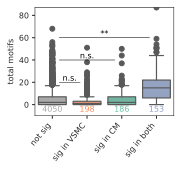

In [50]:
# plot some examples
order1 = ["not_sig_both", "sig_VSMC", "sig_CM","sig_both"]
pal2 = {"not_sig_both": "darkgray", "sig_VSMC": sns.color_palette("Set2")[1], 
        "sig_CM": sns.color_palette("Set2")[0], "sig_both": sns.color_palette("Set2")[2]}


tmp = data_elem_mot.copy()

fig, ax = plt.subplots(figsize=(2.5, 2), nrows=1, ncols=1)

sns.boxplot(data=tmp, x="sig_status_active", y=(tmp["total_motifs"]), order=order1, palette=pal2, 
            flierprops = dict(marker='o', markersize=5), ax=ax)
mimic_r_boxplot(ax)
ax.set_xticklabels(["not sig", "sig in VSMC", "sig in CM", "sig in both"], rotation=50, 
                   ha="right", va="top")
ax.set_ylabel("total motifs")
ax.set_title("")
ax.set_xlabel("")

for i, label in enumerate(order1):
    n = len(tmp[tmp["sig_status_active"] == label])
    ax.annotate(str(n), xy=(i, -0.9), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='top', 
                color=pal2[label], size=fontsize)

ax.set_ylim((-10, max(tmp['total_motifs'])))
#ax.set_ylim((-1.5, 4))


# calc p-vals b/w dists
dist1 = np.asarray(tmp[tmp["sig_status_active"] == "not_sig_both"]["total_motifs"])
dist2 = np.asarray(tmp[tmp["sig_status_active"] == "sig_VSMC"]["total_motifs"])
dist3 = np.asarray(tmp[tmp["sig_status_active"] == "sig_CM"]["total_motifs"])
dist4 = np.asarray(tmp[tmp["sig_status_active"] == "sig_both"]["total_motifs"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]
dist3 = dist3[~np.isnan(dist3)]
dist4 = dist4[~np.isnan(dist4)]

u, pval1 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
u, pval2 = stats.mannwhitneyu(dist1, dist3, alternative="two-sided", use_continuity=False)
u, pval3 = stats.mannwhitneyu(dist1, dist4, alternative="two-sided", use_continuity=False)
#u, pval3 = stats.mannwhitneyu(dist1, dist4, alternative="two-sided", use_continuity=False)
print(pval1)
print(pval2)
print(pval3)

#annotate_pval(ax, 0.2, 0.8, 5.3, 0, 5.3, pval1, fontsize)
ax.plot([0.2, 0.2, 0.8, 0.8], [20, 20+0, 20+0, 20], c="black", lw=0.5)
if pval2 < 0.001:
    ax.text((0.2+0.8)*.5, 20, '**', ha='center', va='bottom', color="black", size=fontsize)
elif pval2 < 0.05:
    ax.text((0.2+0.8)*.5, 20, '*', ha='center', va='bottom', color="black", size=fontsize)
else:
    ax.text((0.2+0.8)*.5, 20, 'n.s.', ha='center', va='bottom', color="black", size=fontsize)
    
ax.plot([0.2, 0.2, 1.8, 1.8], [40, 40+0, 40+0, 40], c="black", lw=0.5)
if pval2 < 0.001:
    ax.text((0.2+1.8)*.5, 40, '**', ha='center', va='bottom', color="black", size=fontsize)
elif pval2 < 0.05:
    ax.text((0.2+1.8)*.5, 40, '*', ha='center', va='bottom', color="black", size=fontsize)
else:
    ax.text((0.2+1.8)*.5, 40, 'n.s.', ha='center', va='bottom', color="black", size=fontsize)
    
ax.plot([0.2, 0.2, 2.8, 2.8], [60, 60+0, 60+0, 60], c="black", lw=0.5)
if pval3 < 0.001:
    ax.text((0.2+2.8)*.5, 60, '**', ha='center', va='bottom', color="black", size=fontsize)
elif pval3 < 0.05:
    ax.text((0.2+2.8)*.5, 60, '*', ha='center', va='bottom', color="black", size=fontsize)
else:
    ax.text((0.2+2.8)*.5, 60, 'n.s.', ha='center', va='bottom', color="black", size=fontsize)

#annotate_pval(ax, 0.2, 1.8, 7.3, 0, 7.3, pval2, fontsize)
#annotate_pval(ax, 0.2, 2.8, 10.8, 0, 10.8, pval3, fontsize)

#fig.savefig("Fig6_totalmotif_activity_categories.svg", dpi="figure", bbox_inches="tight")
plt.show()

## repeat plots 

In [51]:
### RepeatMasker ####
sentinel_snps = pd.read_table('~/marenostrum/Projects/Breast/ANALYSIS/Hypertension/data/design/sentinel_trait_ld_snps.txt', sep = '\t')
sentinel_snps = sentinel_snps[sentinel_snps['Trait'].isin(['DBP','PP','SBP'])]
sentinel_snps.sample(5)

,sentinel,snp,change,name,E,Chr,coord,Trait
3392,rs6454092,rs4706077,6:79548845:G:A,chr6:79548777:79548912__rs4706077__6:79548845:G:A,G:A,6,chr6:79548777:79548912,DBP
3092,rs6026739,rs7267618,20:57706524:T:G,chr20:57706456:57706591__rs7267618__20:5770652...,T:G,20,chr20:57706456:57706591,DBP
1898,rs3774372,rs7631914,3:41813557:T:C,chr3:41813489:41813624__rs7631914__3:41813557:T:C,T:C,3,chr3:41813489:41813624,PP
3511,rs6595838,rs34790038,5:127862595:A:C,chr5:127862527:127862662__rs34790038__5:127862...,A:C,5,chr5:127862527:127862662,SBP
4039,rs76206723,rs12538229,7:40460129:C:T,chr7:40460061:40460196__rs12538229__7:40460129...,C:T,7,chr7:40460061:40460196,PP


In [52]:
repeat_masker = pd.read_table('~/marenostrum/Projects/Breast/ANALYSIS/Hypertension/data/snps_repeat_masker.info.txt', sep=' ')
repeat_masker['query'] = repeat_masker['query'].str.replace("_1", "")
repeat_masker = repeat_masker.drop_duplicates()
repeat_masker.head()


,query,family,beginR
0,chr10:102604446:102604581,L1PB1,LINE/L1
2,chr10:102615697:102615832,MSTB,LTR/ERVL-MaLR
4,chr10:102617651:102617786,(TTG)n,Simple_repeat
5,chr10:102617651:102617786,AluSx,SINE/Alu
8,chr10:104598927:104599062,MER11A,LTR/ERVK


In [53]:
sentinel = sentinel_snps.merge(repeat_masker, left_on=["coord"], right_on=["query"])

In [54]:
print(sentinel.shape)
sentinel.sample(5)

(2755, 11)


,sentinel,snp,change,name,E,Chr,coord,Trait,query,family,beginR
2420,rs76206723,rs186166891,7:40406876:A:T,chr7:40406808:40406943__rs186166891__7:4040687...,A:T,7,chr7:40406808:40406943,PP,chr7:40406808:40406943,L1PA4,LINE/L1
2266,rs6911827,rs6904385,6:22128938:A:T,chr6:22128870:22129005__rs6904385__6:22128938:A:T,A:T,6,chr6:22128870:22129005,SBP,chr6:22128870:22129005,L1PREC2,LINE/L1
2421,rs76206723,rs137960410,7:40411544:AACAC:A,chr7:40411476:40411611__rs137960410__7:4041154...,AACAC:A,7,chr7:40411476:40411611,PP,chr7:40411476:40411611,(AC)n,Simple_repeat
1815,rs59476975,rs11714942,3:47775282:A:G,chr3:47775214:47775349__rs11714942__3:47775282...,A:G,3,chr3:47775214:47775349,DBP,chr3:47775214:47775349,AluY,SINE/Alu
978,rs36083386,rs9479195,6:152395269:T:C,chr6:152395201:152395336__rs9479195__6:1523952...,T:C,6,chr6:152395201:152395336,PP,chr6:152395201:152395336,L1MC1,LINE/L1


In [55]:
### activity
vals_significance_cm = pd.read_table('~/marenostrum/Projects/Breast/ANALYSIS/Hypertension/data/02_activs/CM_vals.significance.5.txt', sep = '\t')
vals_significance_cm[["pos", "snp_info","info"]] = vals_significance_cm.name.str.split("__",expand=True)
vals_significance_cm.sample(5)

,CM,CM_pval,CM_padj,element,tile_type,parse_details,name,tile_number,chrom,strand,...,dupe_info,is_snp,CM_log,tile_id,type,sig,full_name,pos,snp_info,info
784,0.152640,0.787510,0.884949,AATATAATACCAAATTCAAAAGGTGGAAAGAAGTTTCTCCTGAGGA...,WILDTYPE_SNP_INDIV,chr16:75465721:75465856__rs34116220__16:754657...,chr16:75465721:75465856__rs34116220__16:754657...,1,chr16,+,...,2772,68.0,-0.816331,2772,WILDTYPE_SNP_INDIV,not sig,chr16:75465721:75465856__rs34116220__16:754657...,chr16:75465721:75465856,rs34116220,16:75465789:A:AG
8920,0.161336,0.730726,0.884949,TTAAGCAGGCTGTTCAATTTAGGGTGATATGGACATGTGCATATTG...,WILDTYPE_SNP_INDIV,chr6:152396877:152397012__rs67737839__6:152396...,chr6:152396877:152397012__rs67737839__6:152396...,1,chr6,+,...,3579,68.0,-0.792270,3579,WILDTYPE_SNP_INDIV,not sig,chr6:152396877:152397012__rs67737839__6:152396...,chr6:152396877:152397012,rs67737839,6:152396945:C:T
6775,0.175213,0.626753,0.884949,GTGCGACCGGCTCTACCTTGTCCAACATCTATCACGCTAATCGCTA...,RANDOM,NaN,RANDOM,0,NaN,NaN,...,3,NaN,-0.756433,3,negative control,not sig,RANDOM_negative control,RANDOM,None,None
842,0.201725,0.407460,0.884949,AATGAATACTTATTGGATTTTTAAACTCAGTAAGCTACTTCTTTAT...,WILDTYPE_SNP_INDIV,chr5:77882748:77882883__rs6863530__5:77882816:...,chr5:77882748:77882883__rs6863530__5:77882816:C:T,1,chr5,+,...,2213,68.0,-0.695239,2213,WILDTYPE_SNP_INDIV,not sig,chr5:77882748:77882883__rs6863530__5:77882816:...,chr5:77882748:77882883,rs6863530,5:77882816:C:T
5084,0.187013,0.529973,0.884949,GAATCAACAGGTTACAACGTCAATGACAAAGGGAGCTCAGACAAGG...,WILDTYPE_SNP_INDIV,chr6:32626416:32626551__rs9273369__6:32626484:...,chr6:32626416:32626551__rs9273369__6:32626484:T:C,1,chr6,+,...,860,68.0,-0.728128,860,WILDTYPE_SNP_INDIV,not sig,chr6:32626416:32626551__rs9273369__6:32626484:...,chr6:32626416:32626551,rs9273369,6:32626484:T:C


In [56]:
vals_significance_vsmc = pd.read_table('~/marenostrum/Projects/Breast/ANALYSIS/Hypertension/data/02_activs/VSMC_vals.significance.4.txt', sep = '\t')
vals_significance_vsmc[["pos", "snp_info","info"]] = vals_significance_vsmc.name.str.split("__",expand=True)
vals_significance_vsmc.sample(5)

,VSMC,VSMC_pval,VSMC_padj,element,tile_type,parse_details,name,tile_number,chrom,strand,...,dupe_info,is_snp,VSMC_log,tile_id,type,sig,full_name,pos,snp_info,info
3318,0.573691,0.042461,0.491644,CAGTCTCACCTGGGTGGCTACAAGATAGATCAGCTCCCCAAGGGTT...,WILDTYPE_SNP_INDIV,chr3:41877346:41877481__rs3774372__3:41877414:...,chr3:41877346:41877481__rs3774372__3:41877414:T:C,1,chr3,+,...,4028,68.0,-0.241322,4028,WILDTYPE_SNP_INDIV,not sig,chr3:41877346:41877481__rs3774372__3:41877414:...,chr3:41877346:41877481,rs3774372,3:41877414:T:C
4099,0.276817,0.489809,0.904140,CCTTCAAGGTGAACTTTACCTTCAACCGCCAGCCGCTGCGAGTCCA...,WILDTYPE_BUT_HAS_SNP,chr1:113237103:113237238__rs883593__1:11323717...,chr1:113237103:113237238__rs883593__1:11323717...,1,chr1,+,...,715,0.0,-0.557807,715,WILDTYPE_BUT_HAS_SNP,not sig,chr1:113237103:113237238__rs883593__1:11323717...,chr1:113237103:113237238,rs883593,1:113237171:A:G
192,0.311126,0.412276,0.904140,AAACACCGCATGTTCTCACTCATAGGTGGGAATTGAACAATGGGAA...,WILDTYPE_SNP_INDIV,chr3:41816473:41816608__rs113722150__3:4181654...,chr3:41816473:41816608__rs113722150__3:4181654...,1,chr3,+,...,3801,68.0,-0.507064,3801,WILDTYPE_SNP_INDIV,not sig,chr3:41816473:41816608__rs113722150__3:4181654...,chr3:41816473:41816608,rs113722150,3:41816541:A:T
5039,0.174494,0.712073,0.904140,GAAGACTAAGGAGACATGACAACTAACTAAATGTGGAAAATGGGTT...,WILDTYPE_BUT_HAS_SNP,chr16:75381882:75382017__rs10459859__16:753819...,chr16:75381882:75382017__rs10459859__16:753819...,1,chr16,+,...,2558,0.0,-0.758221,2558,WILDTYPE_BUT_HAS_SNP,not sig,chr16:75381882:75382017__rs10459859__16:753819...,chr16:75381882:75382017,rs10459859,16:75381950:T:C
9016,0.168276,0.724078,0.904140,TTAGTTTTGAATTTCTGGTCATTTACTCAATCTGGTCATTACTTTC...,WILDTYPE_BUT_HAS_SNP,chr2:96512624:96512759__rs60309670__2:96512692...,chr2:96512624:96512759__rs60309670__2:96512692...,1,chr2,+,...,2833,0.0,-0.773978,2833,WILDTYPE_BUT_HAS_SNP,not sig,chr2:96512624:96512759__rs60309670__2:96512692...,chr2:96512624:96512759,rs60309670,2:96512692:A:ACC


In [57]:
CM_results = pd.read_table('~/marenostrum/Projects/Breast/ANALYSIS/Hypertension/analysis/01_mpra/06_process_mpranalyze_comp/results_comparisons_with_significance.CM.new_back.005.txt', sep='\t')
VSMC_results = pd.read_table('~/marenostrum/Projects/Breast/ANALYSIS/Hypertension/analysis/01_mpra/06_process_mpranalyze_comp/results_comparisons_with_significance.VSMC.new_back.005.txt', sep='\t')


In [58]:
dupe_snp = vals_significance_cm[['dupe_info','snp_info']].drop_duplicates()

In [59]:
dupe_snp.shape

(4707, 2)

In [60]:
CM_results = CM_results[CM_results['tile_type']=='WILDTYPE_SNP_INDIV']
VSMC_results = VSMC_results[VSMC_results['tile_type']=='WILDTYPE_SNP_INDIV']

In [61]:
CM_results['dupe_info'] = CM_results['dupe_info'].astype(int)
VSMC_results['dupe_info'] = VSMC_results['dupe_info'].astype(int)
CM_results = CM_results.merge(dupe_snp, on='dupe_info')
VSMC_results = VSMC_results.merge(dupe_snp, on='dupe_info')
VSMC_results.sample(5)

,Unnamed: 0,index,stat_comp,pval_comp,fdr_comp,df.test_comp,df.dna_comp,df.rna.full_comp,df.rna.red_comp,logFC_comp,dupe_info,is_ctrl,tile_type,native_status,snp_info
4037,4050,3560__WILDTYPE_SNP_INDIV,2.813954,0.093448,0.310780,1.0,24.0,5.0,4.0,0.509607,3560,sequence,WILDTYPE_SNP_INDIV,no effect,rs35396879
4614,4626,199__WILDTYPE_SNP_INDIV,2.063030,0.150910,0.399237,1.0,26.0,5.0,4.0,0.467236,199,sequence,WILDTYPE_SNP_INDIV,no effect,rs11784242
2232,2249,244__WILDTYPE_SNP_INDIV,1.245590,0.264396,0.536525,1.0,26.0,5.0,4.0,-0.248894,244,sequence,WILDTYPE_SNP_INDIV,no effect,rs74695165
652,670,1758__WILDTYPE_SNP_INDIV,0.226262,0.634310,0.822589,1.0,26.0,5.0,4.0,-0.140780,1758,sequence,WILDTYPE_SNP_INDIV,no effect,rs13087550
300,320,535__WILDTYPE_SNP_INDIV,0.011957,0.912925,0.961105,1.0,26.0,5.0,4.0,0.053555,535,sequence,WILDTYPE_SNP_INDIV,no effect,rs11105364


In [62]:
def repeat(row):
    if row["snp_info"] in sentinel['snp'].unique().tolist():
        return "Repeat"
    else:
        return "No Repeat"

In [63]:
vals_significance_cm["Repetitive"] = vals_significance_cm.apply(repeat, axis=1)
vals_significance_cm.head()

,CM,CM_pval,CM_padj,element,tile_type,parse_details,name,tile_number,chrom,strand,...,is_snp,CM_log,tile_id,type,sig,full_name,pos,snp_info,info,Repetitive
0,0.205892,0.373847,0.884949,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,CONTROL_SNP_INDIV,chr3:171858455:171858590__rs6445040__3:1718585...,chr3:171858455:171858590__rs6445040__3:1718585...,1,chr3,+,...,68.0,-0.686360,4625,CONTROL_SNP_INDIV,not sig,chr3:171858455:171858590__rs6445040__3:1718585...,chr3:171858455:171858590,rs6445040,3:171858523:G:A,No Repeat
1,0.407816,0.000002,0.000069,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,CONTROL_BUT_HAS_SNP,chr3:171858455:171858590__rs6445040__3:1718585...,chr3:171858455:171858590__rs6445040__3:1718585...,1,chr3,+,...,0.0,-0.389536,4625,CONTROL_BUT_HAS_SNP,sig,chr3:171858455:171858590__rs6445040__3:1718585...,chr3:171858455:171858590,rs6445040,3:171858523:G:A,No Repeat
2,0.168798,0.676573,0.884949,AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...,CONTROL_SNP_INDIV,chr9:104195602:104195737__rsFakeAldoB101__9:10...,chr9:104195602:104195737__rsFakeAldoB101__9:10...,1,chr9,+,...,68.0,-0.772633,4621,CONTROL_SNP_INDIV,not sig,chr9:104195602:104195737__rsFakeAldoB101__9:10...,chr9:104195602:104195737,rsFakeAldoB101,9:104195670:G:C,No Repeat
3,0.178422,0.600955,0.884949,AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...,CONTROL_BUT_HAS_SNP,chr9:104195602:104195737__rsFakeAldoB101__9:10...,chr9:104195602:104195737__rsFakeAldoB101__9:10...,1,chr9,+,...,0.0,-0.748552,4621,CONTROL_BUT_HAS_SNP,not sig,chr9:104195602:104195737__rsFakeAldoB101__9:10...,chr9:104195602:104195737,rsFakeAldoB101,9:104195670:G:C,No Repeat
4,0.194269,0.469184,0.884949,ACAGACAATAACTCAGTGCCTGGCAAACAGTGAGCACTATGCAAAC...,CONTROL_SNP_INDIV,chr7:151541672:151541807__rs60002611__7:151541...,chr7:151541672:151541807__rs60002611__7:151541...,1,chr7,+,...,68.0,-0.711597,4627,CONTROL_SNP_INDIV,not sig,chr7:151541672:151541807__rs60002611__7:151541...,chr7:151541672:151541807,rs60002611,7:151541740:G:A,No Repeat


In [64]:
vals_significance_vsmc["Repetitive"] = vals_significance_vsmc.apply(repeat, axis=1)
vals_significance_vsmc.head()

,VSMC,VSMC_pval,VSMC_padj,element,tile_type,parse_details,name,tile_number,chrom,strand,...,is_snp,VSMC_log,tile_id,type,sig,full_name,pos,snp_info,info,Repetitive
0,0.267451,0.511170,0.90414,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,CONTROL_SNP_INDIV,chr3:171858455:171858590__rs6445040__3:1718585...,chr3:171858455:171858590__rs6445040__3:1718585...,1,chr3,+,...,68.0,-0.572756,4625,CONTROL_SNP_INDIV,not sig,chr3:171858455:171858590__rs6445040__3:1718585...,chr3:171858455:171858590,rs6445040,3:171858523:G:A,No Repeat
1,0.261744,0.524173,0.90414,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,CONTROL_BUT_HAS_SNP,chr3:171858455:171858590__rs6445040__3:1718585...,chr3:171858455:171858590__rs6445040__3:1718585...,1,chr3,+,...,0.0,-0.582124,4625,CONTROL_BUT_HAS_SNP,not sig,chr3:171858455:171858590__rs6445040__3:1718585...,chr3:171858455:171858590,rs6445040,3:171858523:G:A,No Repeat
2,0.228496,0.598982,0.90414,AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...,CONTROL_SNP_INDIV,chr9:104195602:104195737__rsFakeAldoB101__9:10...,chr9:104195602:104195737__rsFakeAldoB101__9:10...,1,chr9,+,...,68.0,-0.641122,4621,CONTROL_SNP_INDIV,not sig,chr9:104195602:104195737__rsFakeAldoB101__9:10...,chr9:104195602:104195737,rsFakeAldoB101,9:104195670:G:C,No Repeat
3,0.245130,0.561830,0.90414,AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...,CONTROL_BUT_HAS_SNP,chr9:104195602:104195737__rsFakeAldoB101__9:10...,chr9:104195602:104195737__rsFakeAldoB101__9:10...,1,chr9,+,...,0.0,-0.610603,4621,CONTROL_BUT_HAS_SNP,not sig,chr9:104195602:104195737__rsFakeAldoB101__9:10...,chr9:104195602:104195737,rsFakeAldoB101,9:104195670:G:C,No Repeat
4,0.143115,0.770000,0.90414,ACAGACAATAACTCAGTGCCTGGCAAACAGTGAGCACTATGCAAAC...,CONTROL_SNP_INDIV,chr7:151541672:151541807__rs60002611__7:151541...,chr7:151541672:151541807__rs60002611__7:151541...,1,chr7,+,...,68.0,-0.844314,4627,CONTROL_SNP_INDIV,not sig,chr7:151541672:151541807__rs60002611__7:151541...,chr7:151541672:151541807,rs60002611,7:151541740:G:A,No Repeat


In [65]:
vals_significance_cm.Repetitive.value_counts()

Repeat       4964
No Repeat    4751
Name: Repetitive, dtype: int64

In [66]:
order = ["No Repeat", "Repeat"]
palette = {"No Repeat": "gray", "Repeat": sns.color_palette("Set2")[2]}

2.125655022702281e-12


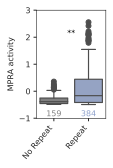

In [67]:
df = vals_significance_cm
#df = df[df['snp_info'].isin(CM_results['snp'])]
df = df[df['CM_padj']<0.05]
fig = plt.figure(figsize=(1.25, 2))
ax = sns.boxplot(data=df, x="Repetitive", y="CM_log", palette=palette, order=order,
                 flierprops = dict(marker='o', markersize=5))
mimic_r_boxplot(ax)

ax.set_xticklabels(["No Repeat", "Repeat"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("MPRA activity")

for i, l in enumerate(order):
    n = len(df[df["Repetitive"] == l])
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='top', 
                color=palette[l], size=fontsize)

ax.set_ylim((-1, 3))

# calc p-vals b/w dists
dist1 = np.asarray(df[df["Repetitive"] == "No Repeat"]["CM_log"])
dist2 = np.asarray(df[df["Repetitive"] != "No Repeat"]["CM_log"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]

u, pval = stats.mannwhitneyu(dist1, dist2, alternative="less", use_continuity=False)
print(pval)

annotate_pval(ax, 0.2, 0.8, 2, 0, 2, pval, fontsize)

plt.show()
#fig.savefig("FigRepeat_CM_activity_act.svg", dpi="figure", bbox_inches="tight")
plt.close()

In [101]:
def repeat(row):
    if row["snp_info"] in sentinel['snp'].unique().tolist():
        return "Repeat"
    else:
        return "No Repeat"

In [106]:
CM_results["Repetitive"] = CM_results.apply(repeat, axis=1)
CM_results.head()

,Unnamed: 0,index,stat_comp,pval_comp,fdr_comp,df.test_comp,df.dna_comp,df.rna.full_comp,df.rna.red_comp,logFC_comp,dupe_info,is_ctrl,tile_type,native_status,snp_info,Repetitive
0,21,2460__WILDTYPE_SNP_INDIV,0.002270,0.962001,0.975808,1.0,26.0,5.0,4.0,-0.004084,2460,sequence,WILDTYPE_SNP_INDIV,no effect,rs9719973,Repeat
1,22,1163__WILDTYPE_SNP_INDIV,1.350091,0.245262,0.373644,1.0,26.0,5.0,4.0,-0.130726,1163,sequence,WILDTYPE_SNP_INDIV,no effect,rs13098128,Repeat
2,23,1115__WILDTYPE_SNP_INDIV,1.966163,0.160856,0.271683,1.0,26.0,5.0,4.0,-0.199032,1115,sequence,WILDTYPE_SNP_INDIV,no effect,rs6682678,Repeat
3,24,2812__WILDTYPE_SNP_INDIV,0.018015,0.893229,0.932034,1.0,9.0,5.0,4.0,-0.068022,2812,sequence,WILDTYPE_SNP_INDIV,no effect,rs28558946,Repeat
4,25,1079__WILDTYPE_SNP_INDIV,8.169896,0.004259,0.014344,1.0,17.0,5.0,4.0,-0.753282,1079,sequence,WILDTYPE_SNP_INDIV,significant effect,rs12125361,Repeat


In [107]:
VSMC_results["Repetitive"] = VSMC_results.apply(repeat, axis=1)
VSMC_results.head()

,Unnamed: 0,index,stat_comp,pval_comp,fdr_comp,df.test_comp,df.dna_comp,df.rna.full_comp,df.rna.red_comp,logFC_comp,dupe_info,is_ctrl,tile_type,native_status,snp_info,Repetitive
0,21,2460__WILDTYPE_SNP_INDIV,0.073462,0.786361,0.899532,1.0,26.0,5.0,4.0,0.059866,2460,sequence,WILDTYPE_SNP_INDIV,no effect,rs9719973,Repeat
1,22,1163__WILDTYPE_SNP_INDIV,0.000241,0.987601,0.993527,1.0,26.0,5.0,4.0,0.004192,1163,sequence,WILDTYPE_SNP_INDIV,no effect,rs13098128,Repeat
2,23,1115__WILDTYPE_SNP_INDIV,0.440261,0.506997,0.742086,1.0,26.0,5.0,4.0,0.293848,1115,sequence,WILDTYPE_SNP_INDIV,no effect,rs6682678,Repeat
3,24,1079__WILDTYPE_SNP_INDIV,4.302640,0.038053,0.182994,1.0,17.0,5.0,4.0,-1.077877,1079,sequence,WILDTYPE_SNP_INDIV,no effect,rs12125361,Repeat
4,25,4308__WILDTYPE_SNP_INDIV,6.866934,0.008781,0.077816,1.0,10.0,5.0,4.0,-1.885874,4308,sequence,WILDTYPE_SNP_INDIV,no effect,rs10707754,Repeat


In [108]:
VSMC_results.Repetitive.value_counts()

Repeat       2475
No Repeat    2188
Name: Repetitive, dtype: int64

0.11737003962715548


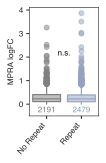

In [115]:
df = CM_results
#df = df[df['snp_info'].isin(VSMC_results['snp'])]
df['abs_ef'] = np.abs(df['logFC_comp'])
fig = plt.figure(figsize=(1.25, 2))
ax = sns.boxplot(data=df, x="Repetitive", y="abs_ef", palette=palette, order=order,
                 flierprops = dict(marker='o', markersize=5))
mimic_r_boxplot(ax)

ax.set_xticklabels(["No Repeat", "Repeat"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("MPRA logFC")

for i, l in enumerate(order):
    n = len(df[df["Repetitive"] == l])
    ax.annotate(str(n), xy=(i, -0.1), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='top', 
                color=palette[l], size=fontsize)

ax.set_ylim((-0.5, 4.1))

# calc p-vals b/w dists
dist1 = np.asarray(df[df["Repetitive"] == "No Repeat"]["abs_ef"])
dist2 = np.asarray(df[df["Repetitive"] != "No Repeat"]["abs_ef"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]

u, pval = stats.mannwhitneyu(dist1, dist2, alternative="greater", use_continuity=False)
print(pval)

annotate_pval(ax, 0.2, 0.8, 2, 0, 2, pval, fontsize)

plt.show()
fig.savefig("FigRepeat_CM_logfc_all.svg", dpi="figure", bbox_inches="tight")
plt.close()

In [116]:
np.mean(dist1)

0.2927658176288842

In [117]:
np.mean(dist2)

0.2925046588918997

## TF repeat plots 

In [68]:
cols = ['chrom', 'actual_start', 'actual_end']
index_elem['query'] = index_elem[cols].apply(lambda row: ':'.join(row.values.astype(str)), axis=1)
index_elem.head()

,element,tile_type,name,unique_name,chrom,strand,actual_start,actual_end,dupe_info,query
0,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,+,106410709,106410844,1,chr7:106410709:106410844
25,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_SNP_INDIV,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,+,106410709,106410844,1,chr7:106410709:106410844
50,TTAGCAACTTTACTAGTCTCATCAATGCAGGAATGGAGGTTACTTG...,WILDTYPE_BUT_HAS_SNP,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925__rs17477177__7:106411...,chr7,+,106411790,106411925,2,chr7:106411790:106411925
75,TTAGCAACTTTACTAGTCTCATCAATGCAGGAATGGAGGTTACTTG...,WILDTYPE_SNP_INDIV,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925__rs17477177__7:106411...,chr7,+,106411790,106411925,2,chr7:106411790:106411925
100,AAAACTAAGATTACAGTTAAAAATTACACTGTGATATATATATATC...,WILDTYPE_BUT_HAS_SNP,chr7:106412014:106412149__rs62481856__7:106412...,chr7:106412014:106412149__rs62481856__7:106412...,chr7,+,106412014,106412149,3,chr7:106412014:106412149


In [69]:
dupe_Repetitive = index_elem['dupe_info'][index_elem['query'].isin(repeat_masker['query'])].unique().tolist()
dupe_Repetitive[1:3]

['3', '6']

In [70]:
def get_repeat_status(row):
    if row.dupe_info in dupe_Repetitive:
        return "Repetitive"
    else:
        return "Not Repetitive"
    
data_elem_mot["Repeat_status_one"] = data_elem_mot.apply(get_repeat_status, axis=1)
data_elem_mot.Repeat_status_one.value_counts()

Repetitive        2475
Not Repetitive    2112
Name: Repeat_status_one, dtype: int64

3.1841155924896693e-09


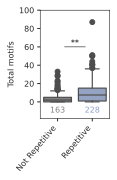

In [74]:
### repeat vs non-repeat
order = ["Not Repetitive", "Repetitive"]
palette = {"Not Repetitive": "gray", "Repetitive": sns.color_palette("Set2")[2]}

fig = plt.figure(figsize=(1.25, 2))
df_filt = data_elem_mot[data_elem_mot["VSMC_status"] != "no effect"]
ax = sns.boxplot(data=df_filt, x="Repeat_status_one", y="total_motifs", palette=palette, order=order,
                 flierprops = dict(marker='o', markersize=5))
mimic_r_boxplot(ax)

ax.set_xticklabels(["Not Repetitive", 'Repetitive'], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("Total motifs")

for i, l in enumerate(order):
    n = len(df_filt[df_filt["Repeat_status_one"] == l])
    ax.annotate(str(n), xy=(i, -5), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='top', 
                color=palette[l], size=fontsize)

ax.set_ylim((-18, 100))

# calc p-vals b/w dists
dist1 = np.asarray(df_filt[df_filt["Repeat_status_one"] == "Not Repetitive"]["total_motifs"])
dist2 = np.asarray(df_filt[df_filt["Repeat_status_one"] != "Not Repetitive"]["total_motifs"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]

u, pval = stats.mannwhitneyu(dist1, dist2, alternative="less", use_continuity=False)
print(pval)

#annotate_pval(ax, 0.2, 0.8, 55, 0, 55, pval, fontsize)
ax.plot([0.2, 0.2, 0.8, 0.8], [60, 60+0, 60+0, 60], c="black", lw=0.5)
if pval < 0.001:
    ax.text((0.2+0.8)*.5, 60, '**', ha='center', va='bottom', color="black", size=fontsize)
elif pval < 0.05:
    ax.text((0.2+0.8)*.5, 60, '*', ha='center', va='bottom', color="black", size=fontsize)
else:
    ax.text((0.2+0.8)*.5, 60, 'n.s.', ha='center', va='bottom', color="black", size=fontsize)

plt.show()
#fig.savefig("Fig3X_Repetitive_diff_CM.svg", dpi="figure", bbox_inches="tight")
plt.close()

### Top disrupted in differential/repetitive 

In [81]:
disruption_CM = pd.read_csv('../../../data/TF_Analysis/motifs_disruptionrep_dif_analysis.CM.txt.gz', sep="\t")
disruption_CM.sample(5)

,index,Differential_pval,Differential_n_disr,Repetitive_pval,Repetitive_n_disr,Differential_padj,Repetitive_padj,Diff_sig,rep_sig,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,All Sequences_enr,Active_enr
59,M06176_1,0.986637,10,0.802490,7,0.996910,0.998789,0,0,13.393724,2.524676e-04,0.001378,0.141760,5.282980e-03,M06176_1,TCF4,activating,0.0,1.0
15,M08865_1,0.660458,17,0.717866,6,0.996910,0.998789,0,0,15.812098,6.995379e-05,0.001627,0.171419,2.001535e-03,M08865_1,KLF11,activating,NaN,1.0
23,M08989_1,0.320184,14,0.835192,9,0.960552,0.998789,0,0,27.096439,1.935542e-07,0.002786,0.270541,1.085452e-05,M08989_1,NR1D1,activating,0.0,1.0
21,M05902_1,0.954853,10,0.774035,7,0.996910,0.998789,0,0,15.027934,1.059315e-04,0.001546,0.156665,2.474818e-03,M05902_1,MESP1,activating,0.0,1.0
10,M05767_1,0.746280,9,0.695025,5,0.996910,0.998789,0,0,41.573234,1.135371e-10,0.004272,0.409480,3.979475e-08,M05767_1,GLIS3,activating,NaN,NaN


In [82]:
disruption_VSMC = pd.read_csv('../../../data/TF_Analysis/motifs_disruptionrep_dif_analysis.VSMC.txt.gz', sep="\t")
disruption_VSMC.sample(5)

,index,Differential_pval,Differential_n_disr,Repetitive_pval,Repetitive_n_disr,Differential_padj,Repetitive_padj,Diff_sig,rep_sig,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,All Sequences_enr,Active_enr
72,M09329_1,0.885269,1,1.000000,0,1.0,1.0,0,0,36.733333,1.354437e-09,0.003775,0.371873,2.109911e-07,M09329_1,ZIC5,activating,NaN,1.0
42,M09185_1,0.718631,5,0.986173,2,1.0,1.0,0,0,15.295291,9.194542e-05,0.001574,0.166490,2.289057e-03,M09185_1,SP9,activating,0.0,1.0
22,M00255_1,0.602335,3,0.728571,3,1.0,1.0,0,0,53.591165,2.468670e-13,0.005503,0.524566,1.730538e-10,M00255_1,MITF,activating,NaN,1.0
14,M08863_1,0.482605,3,1.000000,0,1.0,1.0,0,0,17.980403,2.231909e-05,0.001850,0.191326,7.277063e-04,M08863_1,KLF10,activating,0.0,1.0
37,M09139_1,0.680373,3,0.542729,3,1.0,1.0,0,0,15.313297,9.107320e-05,0.001576,0.159570,2.289057e-03,M09139_1,SNAI1,activating,0.0,1.0


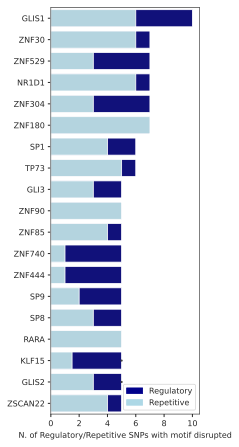

In [90]:
## plot results
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(5.5, 7.5))
tmp = disruption_VSMC[disruption_VSMC["Differential_n_disr"] >= 5].sort_values(by="Differential_n_disr", ascending=False)
#tmp = tmp[tmp["Repetitive_n_disr"]/tmp["Differential_n_disr"] >= 0.8].sort_values(by="Differential_n_disr", ascending=False)
ax1 = plt.subplot2grid((1, 6), (0, 3), colspan=3)

yvals = []
symbs = []
c = 0
for i, row in tmp.iterrows():
    symb = row["HGNC symbol"]
    if symb not in symbs:
        yvals.append(c)
        symbs.append(symb)
        c += 1
    else:
        yvals.append(c)

tmp["yval"] = yvals
#sns.barplot(y="HGNC symbol", x="Differential_n_disr", data=tmp, palette=full_pal, ax=ax1)
# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="Differential_n_disr",  y="HGNC symbol", data=tmp, color='darkblue', ax=ax1)

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="Repetitive_n_disr", y="HGNC symbol", data=tmp, ci=None,  color='lightblue')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='Regulatory')
bottom_bar = mpatches.Patch(color='lightblue', label='Repetitive')
plt.legend(handles=[top_bar, bottom_bar])

ax1.set_ylabel("")
ax1.set_xlabel("N. of Regulatory/Repetitive SNPs with motif disrupted")

plt.show()
fig.savefig("../../../plots/Fig3X_VSMC_motifdisrup_diff_rep_Suppl.svg", dpi="figure", bbox_inches="tight")
plt.close()